In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [22]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("./Ressources/yen.csv"), 
    index_col="Date", 
    infer_datetime_format=True, 
    parse_dates=True)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [23]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

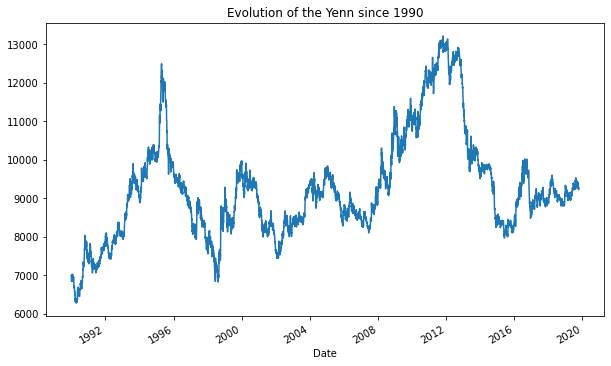

In [24]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize = (10,6), title = "Evolution of the Yenn since 1990");

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [25]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noice, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [26]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_segmented = yen_futures.Settle.to_frame()
yen_segmented["Trend"]= yen_trend
yen_segmented["Noice"]= yen_noice

yen_segmented.head()

,Settle,Trend,Noice
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


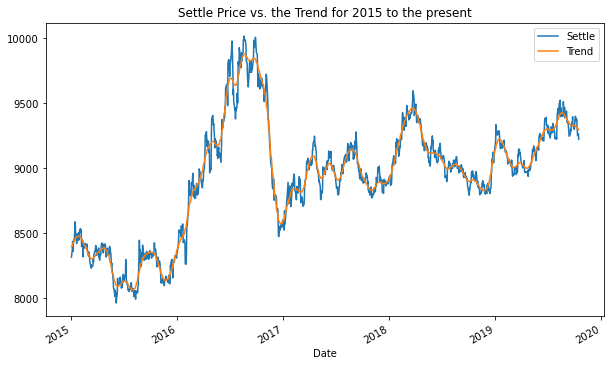

In [27]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_segmented[["Settle", "Trend"]].loc["2015":].plot(figsize=(10,6), title = "Settle Price vs. the Trend for 2015 to the present" );


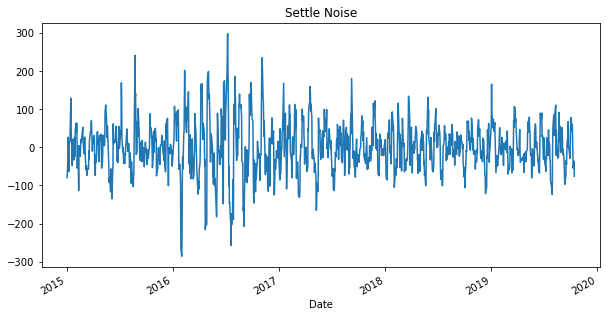

In [28]:
# Plot the Settle Noise for 2015 to the present
yen_segmented.Noice["2015":].plot(figsize = (10,5), title = "Settle Noise");

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [35]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns = returns.replace(np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


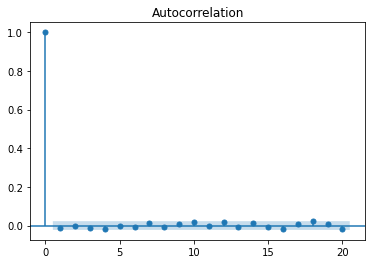

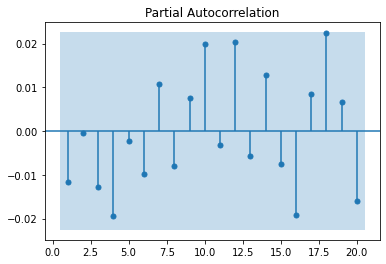

In [36]:
# Import libraries to check the autocorellation in order to determin the factors of the ARMA Function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the yield data
plot_acf(returns.Settle, lags= 20);

# Plot the partial autocorrelation of the yield data
plot_pacf(returns.Settle, lags= 20, zero= False);

In [37]:
# As I encountered some troubles using ARMA, I used the ARIMA with 0 as factor 
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA model using statsmodels (use order=(2, 0 ,1)). This is equivalent to the ARMA model
model_arma = ARIMA(returns.Settle, order=(1, 0, 1))

# Fit the model and assign it to a variable called results
result_arma = model_arma.fit()

C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [38]:
# Output model summary results:
result_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7894.076
Date:                Thu, 09 Dec 2021   AIC                          15796.151
Time:                        22:17:19   BIC                          15823.850
Sample:                             0   HQIC                         15805.662
                               - 7514                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.774      0.439      -0.010       0.022
ar.L1          0.0489      0.763      0.064      0.949      -1.446       1.544
ma.L1         -0.0606      0.762     -0.079      0.937      -1.554       1.433
sigma2         0.4787      0.004    124.324      0.000       0.471       0.486
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17212.01
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


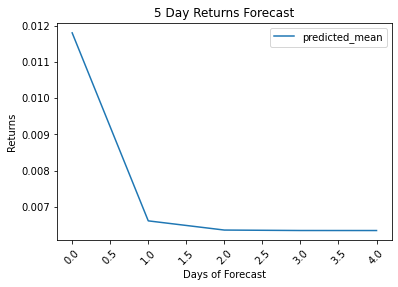

In [39]:
# Plot the 5 Day Returns Forecast
prediction_arma = pd.DataFrame(result_arma.forecast(steps=5)).reset_index().drop(columns = "index")
prediction_arma.plot(title = "5 Day Returns Forecast", rot = 45, ylabel = "Returns", xlabel = "Days of Forecast");

In [34]:
prediction_arma

,predicted_mean
0,0.011805
1,0.006611
2,0.006357
3,0.006345
4,0.006344


---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [44]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

# YOUR CODE HERE!
model_arima = ARIMA(yen_segmented.Settle, order=(5, 1, 1))

# Fit the model and assign it to a variable called results
result_arima = model_arima.fit()

C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [45]:
# Output model summary results:
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7515
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.789
Date:                Mon, 06 Dec 2021   AIC                          83903.577
Time:                        12:34:19   BIC                          83952.049
Sample:                             0   HQIC                         83920.220
                               - 7515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      1.725     -0.004      0.997      -3.389       3.374
ar.L2         -0.0035      0.027     -0.128      0.898      -0.057       0.050
ar.L3         -0.0137      0.011     -1.197      0.231      -0.036       0.009
ar.L4         -0.0176      0.026     -0.674      0.501      -0.069       0.034
ar.L5         -0.0051      0.031     -0.161      0.872      -0.067       0.057
ma.L1         -0.0076      1.725     -0.004      0.996      -3.389       3.373
sigma2      4132.5390     33.382    123.796      0.000    4067.112    4197.966
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13716.71
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


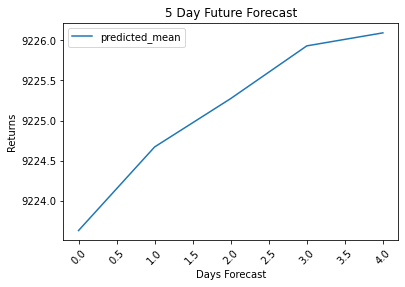

In [46]:
# Plot the 5 Day Price Forecast
prediction_arima = pd.DataFrame(result_arima.forecast(steps=5)).reset_index().drop(columns = "index")
prediction_arima.plot(title = "5 Day Future Forecast", rot = 45, ylabel = "Returns", xlabel = "Days Forecast");

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [52]:
from arch import arch_model

In [54]:
# Estimate a GARCH model:
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
result_garch = model_garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87406254.62884925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.925448485285
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.715051647085
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.8233985962215
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.046068867134
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.737484233749
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.4113697930225
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.2146776534555
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021535648443
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935930634227
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898024664
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643351801
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640221216
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4239912

In [55]:
# Summarize the model results
result_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Dec 06 2021   Df Residuals:                     7514
Time:                        12:38:25   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [56]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [58]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = result_garch.forecast(start= last_day, horizon=forecast_horizon)
forecasts

C:\Users\Thom\anaconda3\envs\project-calculator\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [59]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [60]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


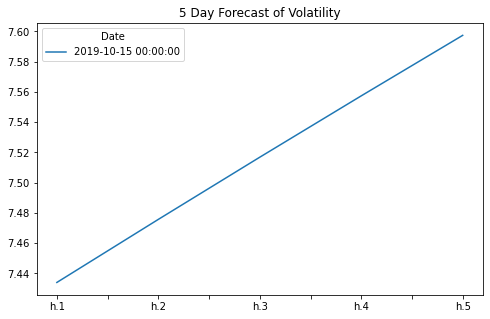

In [63]:
# Plot the final forecast
final.plot(title = "5 Day Forecast of Volatility", figsize = (8,5));

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Based on the results I wouldn't buy Yen unless it is right now, because the return is predicted to decrease. Overall the Yen is predicted to increase for the coming 5 days. The volatility is also increasing which indicate an increasing risk. This is emphasis the position not to buy.
Finaly I wouldn't use this model for an investement, because the P-value is much bigger than 5%. I would change the parameters of the ARMA and ARIMA to better fit the model. 